In [13]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

import plotly.plotly as py
import plotly.graph_objs as go
pd.options.mode.chained_assignment = None

from sklearn.externals import joblib
import copy

In [3]:
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import cohen_kappa_score, make_scorer, classification_report, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

C:\Users\Kseniya\Anaconda2\envs\py34\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [4]:
os.chdir("../run/")

In [5]:
from utils import CorrelatedRemoval

Read in all data

In [7]:
data_path = '../output/parsed_data/'
flnms = os.listdir(data_path)

df = pd.DataFrame()

for fl in flnms:
    d = pd.read_csv(data_path + fl)
    d = d[d['frame'] > 10]
    df = pd.concat([df, d])
    
bad_amc = ['32_01.amc', '32_02.amc']
df = df[~df['amc_path'].isin(bad_amc)]

In [6]:
# select columns for building model

cols = sorted(df.columns.tolist())

id_target_cols = ['amc_path', 'frame', 'heel_strike_l', 'heel_strike_r', 'support', 'toe_off_l', 'toe_off_r']

motion_cols = [i for i in cols if 'motion' in i]
angle_cols = [i for i in cols if 'angle' in i]

predictors_cols = copy.deepcopy(motion_cols)
predictors_cols.extend(angle_cols)
root_norm = ['root_norm_angle_0',  'root_norm_angle_1',  'root_norm_angle_2']
for root_c in root_norm:
    predictors_cols.remove(root_c)

all_cols = copy.deepcopy(predictors_cols)
all_cols.extend(id_target_cols)

In [7]:
sorted(predictors_cols)

['head_angle_0',
 'head_angle_1',
 'head_angle_2',
 'head_motion_0',
 'head_motion_1',
 'head_motion_2',
 'head_norm_angle_0',
 'head_norm_angle_1',
 'head_norm_angle_2',
 'lclavicle_angle_0',
 'lclavicle_angle_1',
 'lclavicle_angle_2',
 'lclavicle_motion_0',
 'lclavicle_motion_1',
 'lclavicle_norm_angle_0',
 'lclavicle_norm_angle_1',
 'lclavicle_norm_angle_2',
 'lfemur_angle_0',
 'lfemur_angle_1',
 'lfemur_angle_2',
 'lfemur_motion_0',
 'lfemur_motion_1',
 'lfemur_motion_2',
 'lfemur_norm_angle_0',
 'lfemur_norm_angle_1',
 'lfemur_norm_angle_2',
 'lfingers_angle_0',
 'lfingers_angle_1',
 'lfingers_angle_2',
 'lfingers_motion_0',
 'lfingers_norm_angle_0',
 'lfingers_norm_angle_1',
 'lfingers_norm_angle_2',
 'lfoot_angle_0',
 'lfoot_angle_1',
 'lfoot_angle_2',
 'lfoot_motion_0',
 'lfoot_motion_1',
 'lfoot_norm_angle_0',
 'lfoot_norm_angle_1',
 'lfoot_norm_angle_2',
 'lhand_angle_0',
 'lhand_angle_1',
 'lhand_angle_2',
 'lhand_motion_0',
 'lhand_motion_1',
 'lhand_norm_angle_0',
 'lhand_

In [8]:
df = df[all_cols]
df.shape

(24685, 252)

Explore predictors

In [9]:
describe_df = df[predictors_cols].describe().T

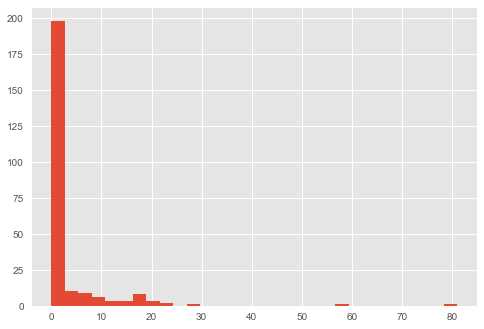

In [10]:
describe_df['std'].hist(bins=30);

In [11]:
describe_df[describe_df['std'] < 1e-2].shape

(12, 8)

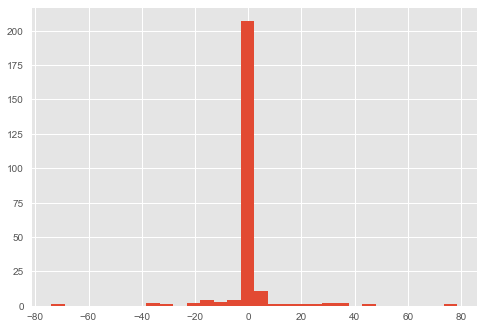

In [12]:
describe_df['mean'].hist(bins=30);

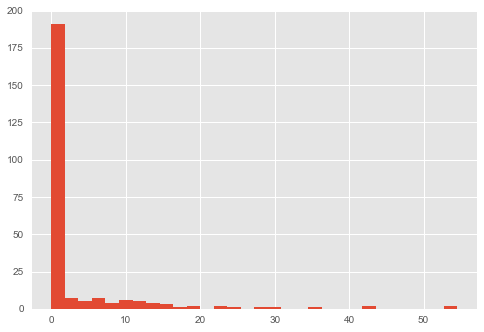

In [13]:
describe_df['iq'] = describe_df['75%'] - describe_df['25%']
describe_df['iq'].hist(bins=30);

In [14]:
describe_df[describe_df['iq'] == 0]

,count,mean,std,min,25%,50%,75%,max,iq
lfingers_motion_0,24685.0,7.12502,2.664589e-15,7.12502,7.12502,7.12502,7.12502,7.12502,0.0
rfingers_motion_0,24685.0,7.12502,2.664589e-15,7.12502,7.12502,7.12502,7.12502,7.12502,0.0


In [15]:
n_uniq = df[predictors_cols].nunique()

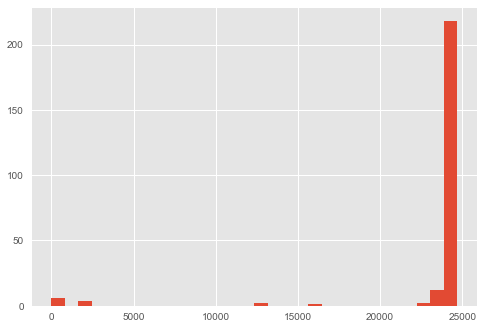

In [16]:
n_uniq.hist(bins=30);

In [17]:
n_uniq.sort_values()[:15]

rfingers_motion_0             1
lfingers_motion_0             1
rhipjoint_norm_angle_1      158
lhipjoint_norm_angle_1      158
rhipjoint_norm_angle_0      192
lhipjoint_norm_angle_0      192
lhipjoint_norm_angle_2     2073
rhipjoint_norm_angle_2     2073
rclavicle_motion_1         2107
lclavicle_motion_1         2107
lclavicle_motion_0        12972
rclavicle_motion_0        12972
root_motion_1             15729
lowerneck_motion_0        22632
rhand_motion_0            22692
dtype: int64

In [18]:
const_feats = ['lfingers_motion_0', 'rfingers_motion_0']
low_var_feats = describe_df[describe_df['std'] < 1e-2].index.tolist()

In [19]:
low_var_feats

['lclavicle_motion_0',
 'lclavicle_motion_1',
 'lfingers_motion_0',
 'rclavicle_motion_0',
 'rclavicle_motion_1',
 'rfingers_motion_0',
 'lhipjoint_norm_angle_0',
 'lhipjoint_norm_angle_1',
 'lhipjoint_norm_angle_2',
 'rhipjoint_norm_angle_0',
 'rhipjoint_norm_angle_1',
 'rhipjoint_norm_angle_2']

Исключим константные и обновим статистики

In [20]:
bad_feats = copy.deepcopy(const_feats)
bad_feats.extend(low_var_feats)
bad_feats = list(set(bad_feats))

for col in bad_feats:
    predictors_cols.remove(col)

In [21]:
describe_df = df[predictors_cols].describe().T

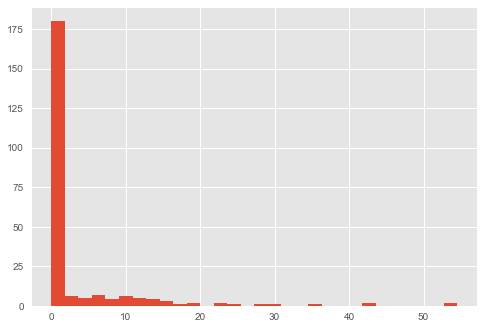

In [22]:
describe_df['iq'] = describe_df['75%'] - describe_df['25%']
describe_df['iq'].hist(bins=30);

In [23]:
describe_df['iq'].sort_values()

lowerback_angle_2          0.040016
upperneck_angle_2          0.044915
upperback_angle_2          0.047187
lowerback_norm_angle_1     0.047459
rclavicle_angle_0          0.059409
thorax_angle_0             0.059409
lclavicle_angle_0          0.059409
rclavicle_angle_2          0.059427
lclavicle_angle_2          0.059427
thorax_angle_2             0.059427
lowerback_angle_1          0.060741
upperback_angle_1          0.062194
head_angle_2               0.066332
lwrist_angle_2             0.075756
lradius_angle_2            0.075756
upperneck_angle_0          0.076056
lowerback_angle_0          0.086245
rclavicle_angle_1          0.090929
lclavicle_angle_1          0.090929
thorax_angle_1             0.090929
lowerneck_angle_1          0.092871
rfemur_angle_2             0.098120
lfemur_angle_2             0.098126
upperneck_angle_1          0.104631
root_angle_1               0.106199
lhipjoint_angle_1          0.106199
rhipjoint_angle_1          0.106199
lfoot_angle_2              0

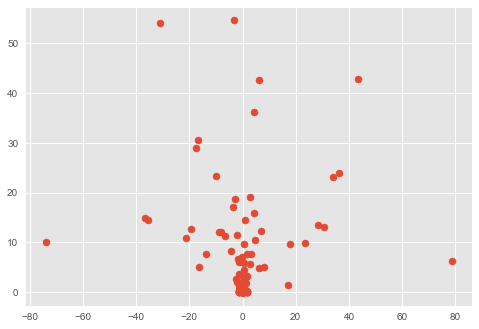

In [24]:
plt.scatter(describe_df['mean'], describe_df['iq']);

Найдем выбросы

In [25]:
describe_df['min_iqr'] = describe_df['25%'] - describe_df['iq'] * 1.5
describe_df['max_iqr'] = describe_df['75%'] + describe_df['iq'] * 1.5

In [26]:
describe_df[describe_df['min_iqr'] > describe_df['min']].shape

(155, 11)

In [27]:
describe_df[describe_df['max_iqr'] < describe_df['max']].shape

(156, 11)

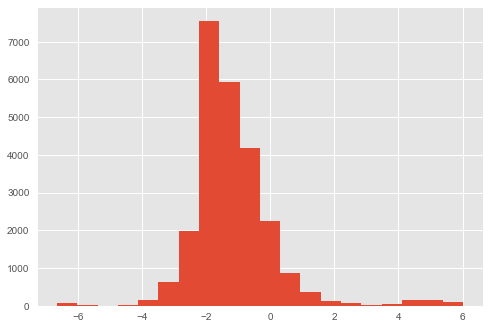

In [28]:
df['head_motion_1'].hist(bins=20);

In [29]:
min_df = describe_df[describe_df['min_iqr'] > describe_df['min']]

min_cols = min_df.index.tolist()

In [30]:
for col in min_cols:
    min_value = min_df.loc[col]['min_iqr']
    df.loc[df[col] < min_value, col] = min_value

In [31]:
max_df = describe_df[describe_df['max_iqr'] < describe_df['max']]
max_cols = max_df.index.tolist()

In [32]:
for col in max_cols:
    max_value = max_df.loc[col]['max_iqr']
    df.loc[df[col] > max_value, col] = max_value

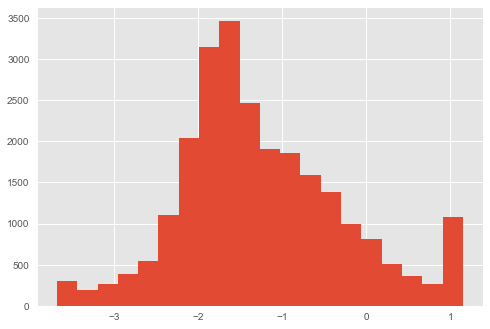

In [33]:
df['head_motion_1'].hist(bins=20);

In [34]:
all_cols = copy.deepcopy(predictors_cols)
all_cols.extend(id_target_cols)

In [35]:
df[all_cols].to_csv('../output/preprocessed_data.csv')

Корреляции

In [31]:
df_cor = df[predictors_cols].corr(method='spearman')

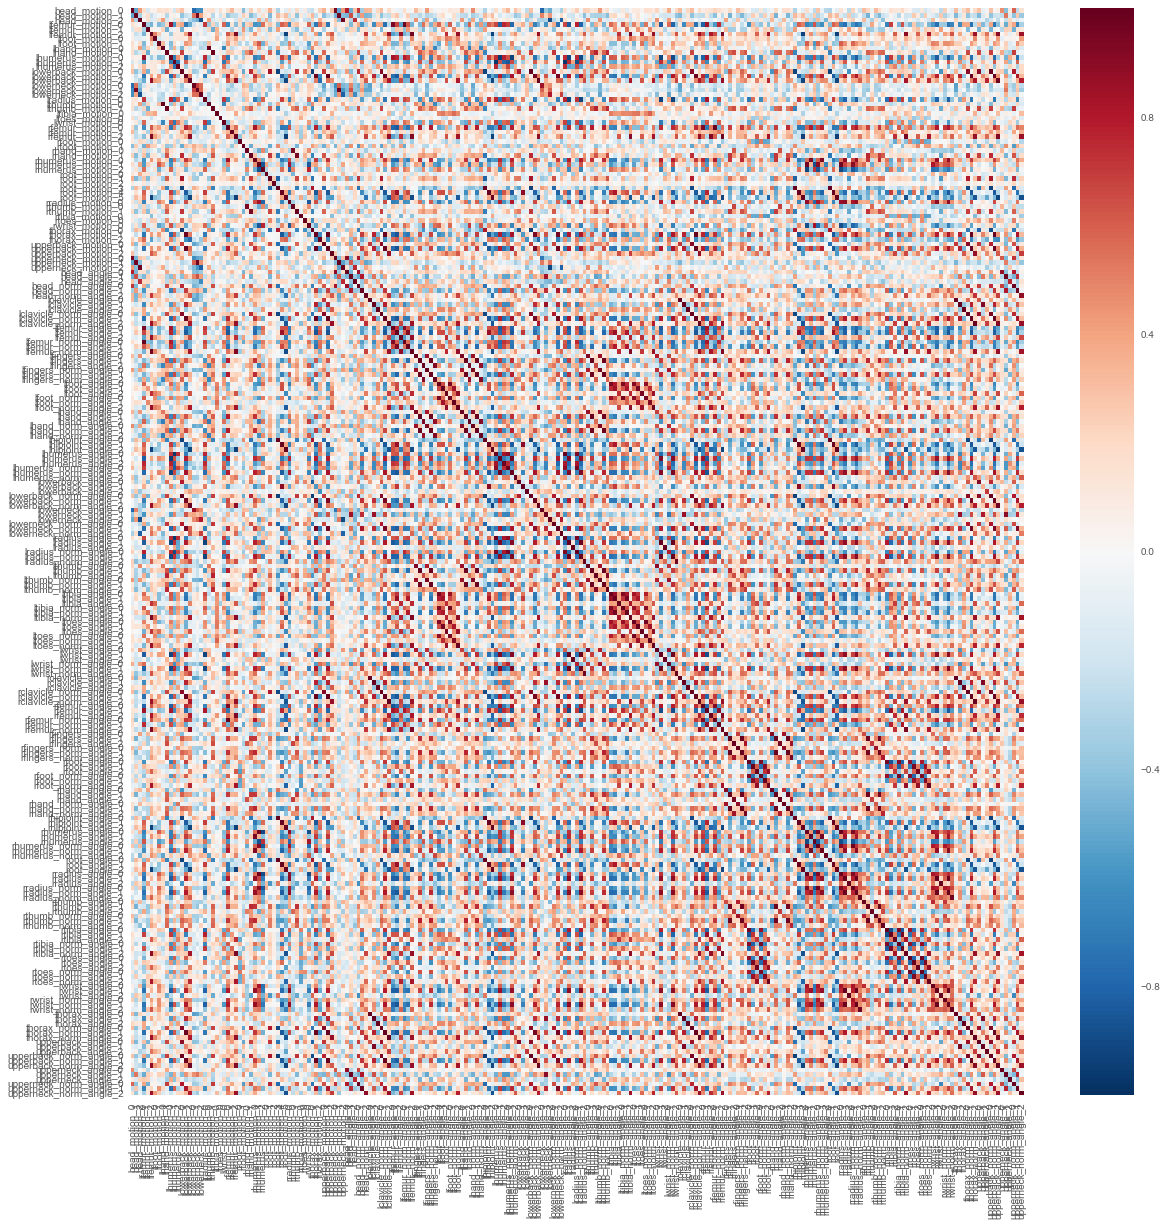

In [33]:
plt.figure(figsize=(20, 20))
sns.heatmap(data=df_cor);

In [34]:
df_corr_unstacked = df_cor.unstack().reset_index()

df_corr_unstacked = df_corr_unstacked.loc[df_corr_unstacked['level_0'] != df_corr_unstacked['level_1'], ]

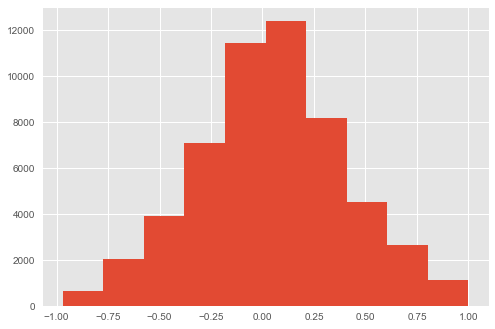

In [36]:
df_corr_unstacked[0].hist();

In [37]:
df['support'].value_counts()

ds     11097
lss     6821
rss     6767
Name: support, dtype: int64

In [165]:
df.reset_index(drop=True, inplace=True)

Попробуем исключение коррелирующих признаков по двум критериям

In [155]:
correm_mi = CorrelatedRemoval(X=df[predictors_cols], y=df['support'], method_xy='mutual_info_classif')

In [156]:
correm_mi.evaluate()

Calculate features correlation ... 
Calculate correlation with target ... 
Sequentially exclude correlated variables ... 


In [157]:
len(predictors_cols)

233

In [158]:
len(correm_mi.all_corr_feats)

165

In [183]:
pr = list(set(predictors_cols) - set(correm_mi.all_corr_feats))

In [192]:
model_pipe = Pipeline([
    ('std_sc', StandardScaler()),
    ('model', LogisticRegression(penalty='l1', C=0.1, class_weight="balanced", random_state=147))  
])

kappa_score_mi = cross_val_score(cv=5, estimator=model_pipe, verbose=True, 
                scoring=make_scorer(cohen_kappa_score), 
                X=df[pr], y=df['support'])

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished


In [198]:
correm_f = CorrelatedRemoval(X=df[predictors_cols], y=df['support'], method_xy='f_classif')

In [199]:
correm_f.evaluate()

Calculate features correlation ... 
Calculate correlation with target ... 
Sequentially exclude correlated variables ... 


In [200]:
len(predictors_cols)

233

In [201]:
len(correm_f.all_corr_feats)

163

In [202]:
pr_f = list(set(predictors_cols) - set(correm_f.all_corr_feats))

In [203]:
model_pipe = Pipeline([
    ('std_sc', StandardScaler()),
    ('model', LogisticRegression(penalty='l1', C=0.1, class_weight="balanced", random_state=147))  
])

kappa_score_f = cross_val_score(cv=5, estimator=model_pipe, verbose=True, 
                scoring=make_scorer(cohen_kappa_score), 
                X=df[pr_f], y=df['support'])

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished


In [205]:
print("Mean Kappa for mutual_inf: {}".format(np.mean(kappa_score_mi)))
print("Std Kappa for mutual_inf: {}".format(np.std(kappa_score_mi)))

print("Mean Kappa for f_classif: {}".format(np.mean(kappa_score_f)))
print("Std Kappa for f_classif: {}".format(np.std(kappa_score_f)))

Mean Kappa for mutual_inf: 0.897735235391633
Std Kappa for mutual_inf: 0.026803393423616872
Mean Kappa for f_classif: 0.8866576726168726
Std Kappa for f_classif: 0.031743700170462325


Будем использовать критерий mutual information

In [210]:
final_all_cols = copy.deepcopy(id_target_cols)
final_all_cols.extend(pr)

In [213]:
df_data = df[final_all_cols]

In [212]:
df_data.to_csv('../output/support_data.csv')

Загрузка из файла

df_data = pd.read_csv('../output/support_data.csv', index_col=0)

id_target_cols = ['amc_path', 'frame', 'heel_strike_l', 'heel_strike_r', 'support', 'toe_off_l', 'toe_off_r']

pr = list(set(df_data.columns.tolist()) - set(id_target_cols))

In [19]:
scores_dict = {}

In [22]:
models = {
    'lr': LogisticRegression(penalty='l1', C=0.1, class_weight="balanced", random_state=147),
    'rf': RandomForestClassifier(class_weight="balanced", max_depth=6, n_estimators=500, random_state=147),
    'lda': LinearDiscriminantAnalysis(),
    'qda': QuadraticDiscriminantAnalysis(),
    'knn': KNeighborsClassifier(n_neighbors=10),
    'gb': GradientBoostingClassifier(n_estimators=100, max_depth=5)
}

for name, model in tqdm.tqdm_notebook(models.items()):
    model_pipe = Pipeline([
        ('std_sc', StandardScaler()),
        ('model', model)  
    ])

    sc = cross_val_score(cv=5, estimator=model_pipe, verbose=True, 
                    scoring=make_scorer(cohen_kappa_score), 
                    X=df_data[pr].values, y=df_data['support'].values)
    scores_dict[name] = sc

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.9min finished
C:\Users\Kseniya\Anaconda2\envs\py34\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning:

The priors do not sum to 1. Renormalizing

C:\Users\Kseniya\Anaconda2\envs\py34\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning:

The priors do not sum to 1. Renormalizing

C:\Users\Kseniya\Anaconda2\envs\py34\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning:

The priors do not sum to 1. Renormalizing

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished


In [23]:
scores_dict

{'gb': array([ 0.86020283,  0.89241554,  0.94725964,  0.93894433,  0.93303266]),
 'knn': array([ 0.69317539,  0.73721118,  0.88433631,  0.85796968,  0.80885839]),
 'lda': array([ 0.78676983,  0.87626759,  0.91106521,  0.90025198,  0.8667023 ]),
 'lr': array([ 0.84740552,  0.89564534,  0.9208633 ,  0.91720271,  0.90817981]),
 'qda': array([ 0.24517289,  0.747513  ,  0.83337755,  0.81205257,  0.63924488]),
 'rf': array([ 0.84750616,  0.87387224,  0.89884276,  0.91613943,  0.90862711])}

Mean Kappa score for qda is : 0.6554721773925692
Mean Kappa score for rf is : 0.8889975397694636
Mean Kappa score for lda is : 0.8682113833831723
Mean Kappa score for knn is : 0.7963101919784441
Mean Kappa score for lr is : 0.8978593351826778
Mean Kappa score for gb is : 0.914371000092941


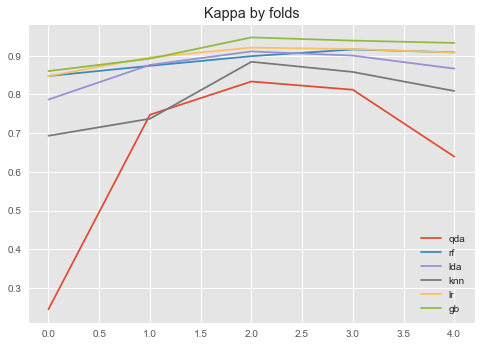

In [24]:
for name, scores in scores_dict.items():
    plt.plot(scores, label=name)
    print("Mean Kappa score for {} is : {}".format(name, np.mean(scores)))
plt.legend(loc=0)
plt.title('Kappa by folds');

Выбераем бустинг в качестве основной модели

Посмотрим качество при разбивке на обучение/тест

In [25]:
skf = StratifiedShuffleSplit(test_size=0.3, random_state=147, n_splits=1)
for train_index, test_index in skf.split(X=df_data[pr], y=df_data['support'].values):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df_data.loc[train_index, pr], df_data.loc[test_index, pr]
    y_train, y_test = df_data.loc[train_index, 'support'], df_data.loc[test_index, 'support']

TRAIN: [ 9939 12539  5481 ...,   207 14690  7938] TEST: [ 6921 17002 23234 ..., 18633  2360 23462]


In [26]:
model_pipe = Pipeline([
    ('std_sc', StandardScaler()),
    ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=5))  
])

In [27]:
model_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('std_sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gb', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [28]:
proba = model_pipe.predict_proba(X_test)

pred = model_pipe.predict(X_test)

In [29]:
accuracy_score(y_pred=pred, y_true=y_test)

0.97056440723737514

In [30]:
cohen_kappa_score(y1=y_test, y2=pred)

0.95446751039592259

In [31]:
print(classification_report(y_pred=pred, y_true=y_test))

             precision    recall  f1-score   support

         ds       0.97      0.97      0.97      3329
        lss       0.98      0.97      0.98      2047
        rss       0.96      0.97      0.97      2030

avg / total       0.97      0.97      0.97      7406



In [32]:
pred_df = pd.DataFrame(proba, columns=['ds', 'lss', 'rss'])
pred_df['pred_class'] = pred

In [33]:
pred_df['prob_pred_class'] = 0
pred_df.loc[pred_df['pred_class'] == 'ds', 'prob_pred_class'] = pred_df.loc[pred_df['pred_class'] == 'ds', 'ds']
pred_df.loc[pred_df['pred_class'] == 'lss', 'prob_pred_class'] = pred_df.loc[pred_df['pred_class'] == 'lss', 'lss']
pred_df.loc[pred_df['pred_class'] == 'rss', 'prob_pred_class'] = pred_df.loc[pred_df['pred_class'] == 'rss', 'rss']

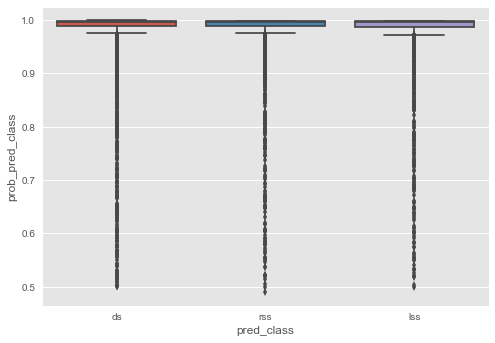

In [34]:
sns.boxplot(data=pred_df, x='pred_class', y='prob_pred_class');

In [38]:
gb = model_pipe.steps[-1][1]

feat_imp = pd.DataFrame([X_train.columns.tolist(), gb.feature_importances_.tolist()]).T
feat_imp.columns = ['feat', 'imp']
feat_imp.sort_values('imp', ascending=False, inplace=True)

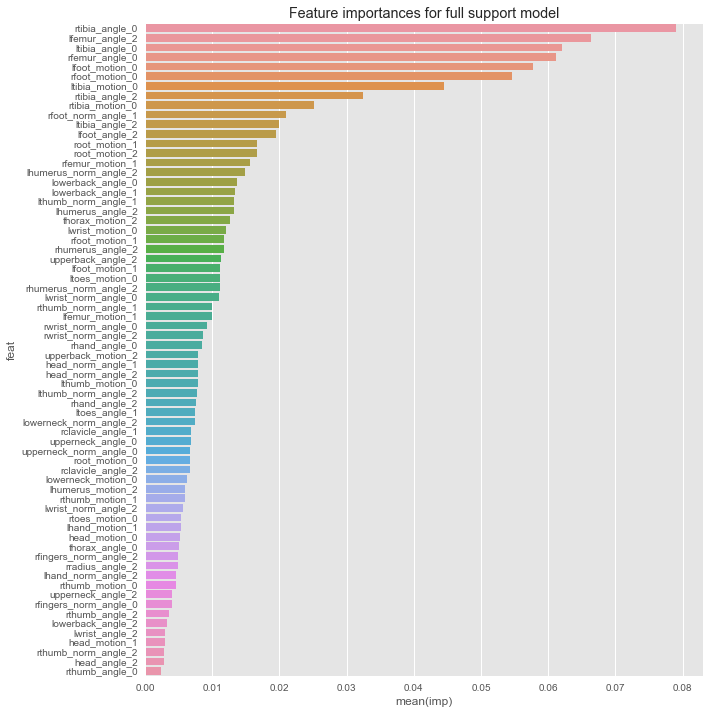

In [41]:
plt.figure(figsize=(10, 12))
sns.barplot(data=feat_imp, y='feat', x='imp', orient='h')
plt.title('Feature importances for full support model');

In [37]:
joblib.dump(filename='../output/full_support.pkl', value=model_pipe)

['../output/full_support.pkl']

Stratified KFold for best model

In [6]:
df_data = pd.read_csv('../output/support_data.csv', index_col=0)

id_target_cols = ['amc_path', 'frame', 'heel_strike_l', 'heel_strike_r', 'support', 'toe_off_l', 'toe_off_r']

pr = list(set(df_data.columns.tolist()) - set(id_target_cols))

In [9]:
skf = StratifiedKFold(n_splits=7, random_state=147, shuffle=True)

model_pipe = Pipeline([
    ('std_sc', StandardScaler()),
    ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=5))  
])

all_res = pd.DataFrame()

In [10]:
for train_index, test_index in tqdm.tqdm_notebook(skf.split(X=df_data[pr], y=df_data['support'].values)):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df_data.loc[train_index, pr], df_data.loc[test_index, pr]
    y_train, y_test = df_data.loc[train_index, 'support'], df_data.loc[test_index, 'support']
    model_pipe.fit(X_train, y_train)
    proba = model_pipe.predict_proba(X_test)
    pred = model_pipe.predict(X_test)
    clas_r = classification_report(y_pred=pred, y_true=y_test).split()[-4:-1] 
    metr = {
        'accuracy': accuracy_score(y_pred=pred, y_true=y_test),
        'kappa': cohen_kappa_score(y1=y_test, y2=pred),
        'precision': clas_r[0],
        'recall': clas_r[1], 
        'f1': clas_r[2]
    }
    all_res = pd.concat([all_res, pd.DataFrame([metr])])
    
all_res['f1'] = all_res['f1'].astype('float32')
all_res['precision'] = all_res['precision'].astype('float32')
all_res['recall'] = all_res['recall'].astype('float32')

TRAIN: [    1     2     3 ..., 24682 24683 24684] TEST: [    0     6     8 ..., 24671 24675 24676]
TRAIN: [    0     1     2 ..., 24681 24683 24684] TEST: [   11    14    16 ..., 24657 24662 24682]
TRAIN: [    0     2     3 ..., 24682 24683 24684] TEST: [    1    10    12 ..., 24645 24665 24681]
TRAIN: [    0     1     2 ..., 24681 24682 24684] TEST: [   31    35    37 ..., 24673 24678 24683]
TRAIN: [    0     1     2 ..., 24682 24683 24684] TEST: [    7     9    15 ..., 24672 24674 24679]
TRAIN: [    0     1     2 ..., 24681 24682 24683] TEST: [    3     4     5 ..., 24666 24680 24684]
TRAIN: [    0     1     3 ..., 24682 24683 24684] TEST: [    2    18    20 ..., 24647 24658 24677]



In [12]:
all_res.mean()

accuracy     0.974843
f1           0.972857
kappa        0.961105
precision    0.972857
recall       0.972857
dtype: float64